In [1]:
import sys
sys.path.append("..")
from pathlib import Path
from importlib import reload

import xarray as xr
import xnemogcm as xn
import xgcm

# temporary fix for the xgcm.Grid.transform deprecation warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 


from pyCDFTOOLS import analysis, in_out
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# try opening
base_dir = "/home/jclmak/data/NEMO_data/UNAGI/EXP_R025/"  # mesh_mask lives here
data_dir = base_dir + "split_100km/alp0060_lam80/tau100x/OUTPUTS/"

domcfg = xn.open_domain_cfg(base_dir)

# opening file already in _grid_T.nc convention; going to load everything into one object
ds = xn.open_nemo_and_domain_cfg(
    domcfg_files=base_dir,
    nemo_files=[data_dir + "UNAGI_10y_08010101_08101230_grid_T.nc",
                data_dir + "UNAGI_10y_08010101_08101230_grid_U.nc",
                data_dir + "UNAGI_10y_08010101_08101230_grid_V.nc"],
)

# open files not in the _grid_T.nc convention (note domcfg goes AFTER positions here)
data_dir = base_dir + "split_100km/alp0060_lam80/tau100x/ANALYSIS/"
ds_moc = xn.process_nemo(
    positions=[
        (xr.open_dataset(data_dir + "UNAGI_5d_08010101_08020101_MOC_T.nc"), 'T'),
        (xr.open_dataset(data_dir + "UNAGI_5d_08010101_08020101_MOC_U.nc"), 'U'),
        (xr.open_dataset(data_dir + "UNAGI_5d_08010101_08020101_MOC_V.nc"), 'V'),
    ],
    domcfg=domcfg,
)

# could merge into one if you want (depends if you want multiple objects floating around)
# warning: if "t_bound" clash, then at risk of the ds data variables being killed (NaNs)
# ds = ds.merge(ds_1y, compat="override")
# del ds_1  # free up the object

/home/jclmak/miniconda3/envs/py311/lib/python3.11/site-packages/dask/_task_spec.py:758: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/jclmak/miniconda3/envs/py311/lib/python3.11/site-packages/dask/_task_spec.py:758: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/jclmak/miniconda3/envs/py311/lib/python3.11/site-packages/dask/_task_spec.py:758: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/jclmak/miniconda3/envs/py311/lib/python3.11/site-packages/dask/_task_spec.py:758: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/jclmak/miniconda3/envs/py311/lib/python3.11/site-packages/xgcm/transform.py:81: RuntimeWarning: divide by zero encountered in log
  theta = np.log(theta)
/home/jclmak/miniconda3/envs/py311/lib/python3.11/site-packages/numba/np/ufunc/gufunc.py:261: RuntimeWarning: divide by zero encountered in _interp_

In [3]:
# generate the grid object

Static_e3 = True
metrics_dict = xn.get_metrics(ds)
if Static_e3:
    metrics_dict[('Z',)] = ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0']

# tidy up of metrics: EW peridicity seems to screw up the metrics at the perodic points in NEMO4.0 leading to
#                     divide by zeros, just add it back in

for points in ["t", "u", "v", "f"]:
    ds[f"e1{points}"][:,  0] = ds[f"e1{points}"][:,  1].values
    ds[f"e1{points}"][:, -1] = ds[f"e1{points}"][:,  0].values
    ds[f"e2{points}"][:,  0] = ds[f"e2{points}"][:,  1].values
    ds[f"e2{points}"][:, -1] = ds[f"e2{points}"][:,  0].values
    
    ds[f"e3{points}_0"][:,  0] = ds[f"e3{points}_0"][:,  1].values
    ds[f"e3{points}_0"][:, -1] = ds[f"e3{points}_0"][:,  0].values
    
# either 1) let xgcm figure out the positions
# coords = None

# or 2) specify it (below should be right for NEMO convention; things are shifted to the RIGHT)
coords = {"X": {"right": "x_f", "center":"x_c"},  # xU > xT
          "Y": {"right": "y_f", "center":"y_c"},  # yV > yT
          "Z": {"center": "z_c", "left": "z_f"},  # zW < zT !!! (?)
          "T": {"center": "t"},
          }

# NOTE: some of the subroutines will modify the specification accordingly (e.g. z co-ord transforms)

# specify periodicity with a list
grid = xgcm.Grid(ds, coords=coords, metrics=metrics_dict, periodic=["X"])

bd = {'boundary':'fill', 'fill_value':0}

In [4]:
# [23 May 2025] stuff seems to be chunked weirdly after update, brute force the chunking
ds = ds.chunk(chunks={"x_c" : -1, "x_f" : -1, 
                      "z_c" : -1, "z_f" : -1})
ds.chunks

Frozen({'z_c': (30,), 'axis_nbounds': (2,), 't': (1,), 'y_c': (98,), 'x_c': (360,), 'x_f': (360,), 'y_f': (98,), 'z_f': (30,)})

### cdfcurl (vorticity)

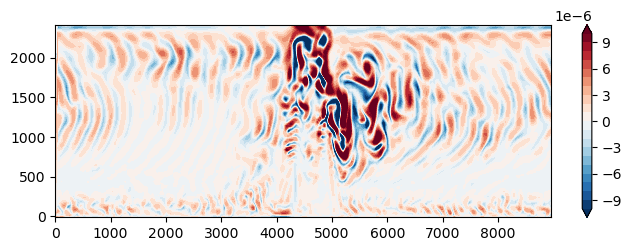

In [5]:
# reload(analysis)

# there might be NaN's in the data for some reason...? 
# pass data per time frame (in line with t_bound in ds; ugly, to tidy)

kt = 2
jk = 0

xi = analysis.cdfcurl(grid, ds, ds_moc.uoce.isel(t=kt), ds_moc.voce.isel(t=kt), **bd)

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(xi.glamf[:, :-1], xi.gphif[:, :-1], xi[jk, :, :-1],
                 levels=np.linspace(-1e-5, 1e-5, 21), cmap="RdBu_r", extend="both")
plt.colorbar(cs)

In [ ]:
# test write of data (promote to dataset first)
# in_out.save_netcdf(xi)

## cdfmoc (averaging at fixed depth)

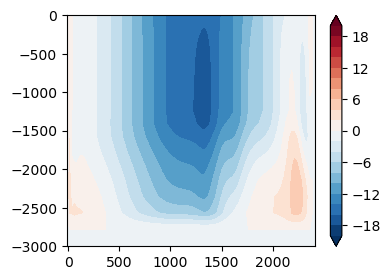

In [6]:
# reload(analysis)

# data here in ds is already tavg in NEMO over 10 years
moc = analysis.cdfmoc(grid, ds, ds.voce.isel(t=0) * ds.e3v_0, **bd)

# TODO/FIX: xgcm currently does not have cumsum/int direction, need to reverse things manually...
#           the output here is "flipped" in z, needs to be flipped

# great big deep reaching (unphysical) Deacon cell, as expected
fig = plt.figure(figsize=(4, 3))
ax = plt.axes()
cs = ax.contourf(moc.gphiv, -moc.gdepw_1d, moc,
                 levels=np.linspace(-20, 20, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

## cdfzonalmean (along i-direction)

Text(0.5, 1.0, '$\\overline{v}$')

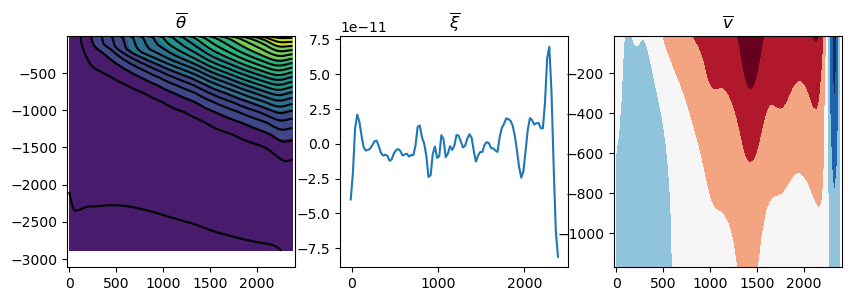

In [7]:
# reload(analysis)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

dum = analysis.cdfzonalmean(grid, ds, ds.toce, **bd)
axs[0].contourf(dum.gphit, -dum.gdept_1d, dum.isel(t=0))
axs[0].contour(dum.gphit, -dum.gdept_1d, dum.isel(t=0), 20, colors='k')
axs[0].set_title(r"$\overline{\theta}$")

dum = analysis.cdfzonalmean(grid, ds, xi, **bd)
axs[1].plot(dum.gphif, dum[jk, :])
axs[1].set_title(r"$\overline{\xi}$")

dum = analysis.cdfzonalmean(grid, ds, ds.uoce[:, 1:20, :, :], **bd)
axs[2].contourf(dum.gphiu, -dum.gdept_1d, dum.isel(t=0), cmap="RdBu_r", extend="both")
axs[2].set_title(r"$\overline{v}$")


## cdfz2sig (vertical co-ordinate transformation)

Useful subroutine probably, intermediary for doing averaging in density co-ordinates (e.g. `cdfmocsig`).
Can in principle do any co-ordinate transformation (e.g. z -> z).

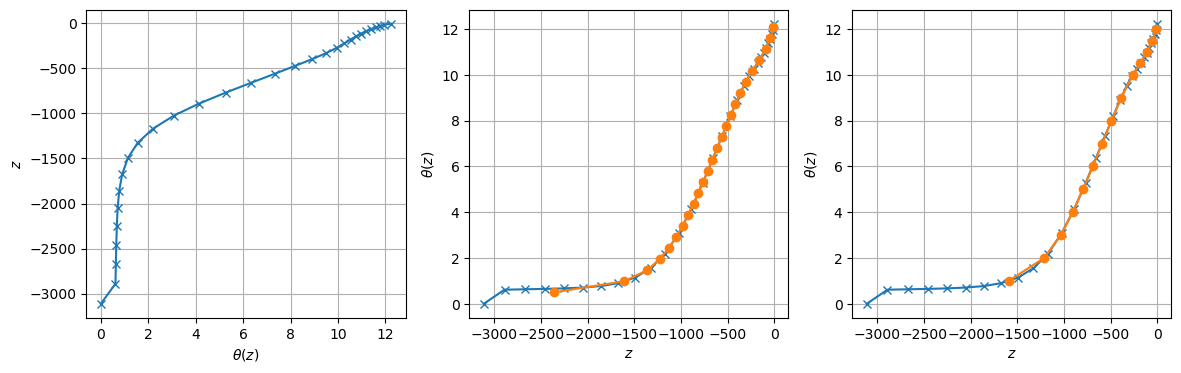

In [8]:
# demonstrating the use of xgcm.transform in the vertical co-ordinate first

# linear and log interp, only from z -> sigma (sigma is just a placeholder)

# reload(analysis)

theta = ds.toce[0, :, 80, 40]

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].plot(theta, -theta.gdept_1d, 'C0-x')
axs[0].set_xlabel(r"$\theta(z)$")
axs[0].set_ylabel(r"$z$")
axs[0].grid()

# TODO: Grid.transform call kicks up a deprecation error but may be a bug?
#       (https://github.com/xgcm/xgcm/discussions/585)
#       suppressing for now

theta_coord = np.linspace(0.5, 15, 31)
z_sigma = analysis.cdfz2sig(grid, ds, -theta.gdept_1d, theta, theta_coord, **bd)


axs[1].plot(-theta.gdept_1d, theta, 'C0-x')
axs[1].plot(z_sigma, z_sigma.sigma, 'C1-o')
axs[1].set_xlabel(r"$z$")
axs[1].set_ylabel(r"$\theta(z)$")
axs[1].grid()

# artificially stretched coordinate
theta_coord = np.asarray([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                          10.5, 11.0, 11.5, 12.0, 12.25, 12.50, 12.75, 13.0,
                          13.2, 13.4, 13.6, 13.8, 14.0,
                          14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0])
z_sigma = analysis.cdfz2sig(grid, ds, -theta.gdept_1d, theta, theta_coord, method="log", **bd)

axs[2].plot(-theta.gdept_1d, theta, 'C0-x')
axs[2].plot(z_sigma, z_sigma.sigma, 'C1-o')
axs[2].set_xlabel(r"$z$")
axs[2].set_ylabel(r"$\theta(z)$")
axs[2].grid()

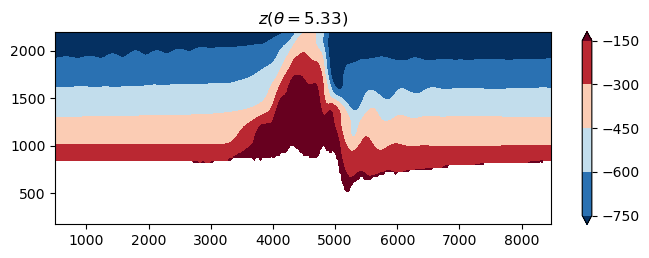

In [9]:
# project the height field onto a sigma surface

theta = ds.toce[0, :, 8:90, 20:340]  # chunk this for the hell of it
theta_coord = np.linspace(0.5, 15, 31)

# promote gdept_1d from 1d to 3d by multiplying the mask
z_sigma = analysis.cdfz2sig(grid, ds, 
                            -theta.gdept_1d * ds.tmask[:, 8:90, 20:340], 
                            theta, 
                            theta_coord, **bd)
    
# plotting quantity on an theta surface
sigma_ind = 10

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(z_sigma.glamt, z_sigma.gphit, 
                 z_sigma[sigma_ind], cmap="RdBu_r", extend="both")
ax.set_title(r"$z(\theta = %.2f)$" % z_sigma.sigma[sigma_ind].values)
plt.colorbar(cs)

In [10]:
# random point above that is displayed as nan, and check there are in fact no valid values
# should return as True
all(theta[20, 70].values < z_sigma.sigma[sigma_ind].values)

True

## cdfmocsig (averaging in density co-ordinates)

Expects the thickness weighted velocity (i.e. `v * e3v`, a transport, possibly with a factor of `e1v`), which is then transformed into density space conservatively.

* Need to do something about the xgcm warnings about transform being in Grid instad of Axis (kicking out a warning per evaluation at the moment...)

In [94]:
# reload(analysis)

# define target co-ord 
# NOTE: subroutine assumes ocean TOP to BOTTOM arrangement (low to high dens, high to low temp)
theta_coord = np.linspace(0.5, 15, 61)

# define subslices in time and space for whatever reason (only need below for subslicing)
kt = slice(0, 5)  # if end=None, then takes the whole slice
# voce_e3v = (ds_moc.voce.isel(t=kt) + ds_moc.voce_eiv.isel(t=kt)) * ds.e3v_0
voce_e3v = ds_moc.voce.isel(t=kt) * ds.e3v_0

# call routine (vertical transform + compting + averaging in target co-ords)
sigma_moc = analysis.cdfsigmamoc(grid, ds, 
                                 voce_e3v, 
                                 ds_moc.toce.isel(t=kt), 
                                 theta_coord,
                                 sigma_coord_dens_like = False,
                                 disp=False, **bd)

voce_eiv_e3v = ds_moc.voce_eiv.isel(t=kt) * ds.e3v_0
sigma_eiv_moc = analysis.cdfsigmamoc(grid, ds, 
                                     voce_eiv_e3v, 
                                     ds_moc.toce.isel(t=kt), 
                                     theta_coord, 
                                     sigma_coord_dens_like = False,
                                     disp=False, **bd)

routine can be costly and a bit slow, have disp=True to display some progress
 
routine can be costly and a bit slow, have disp=True to display some progress
 


In [12]:
# do a writeout then re-read

# in_out.save_netcdf(sigma_moc, varname="sigma_moc", filename="sigma_moc.nc")
# in_out.save_netcdf(sigma_eiv_moc, varname="sigma_eiv_moc", filename="sigma_eiv_moc.nc")

# del sigma_moc, sigma_eiv_moc

# sigma_moc = xr.open_dataset("sigma_moc.nc")
# sigma_eiv_moc = xr.open_dataset("sigma_eiv_moc.nc")

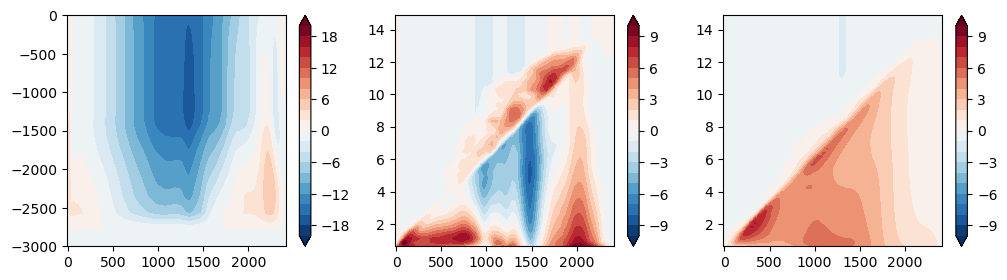

In [95]:
# MOC in both co-ordinates for comparison

# time-averaging done in z co-ordinates
z_moc = analysis.cdfmoc(grid, ds, ds_moc.voce.mean(dim="t")  * ds.e3v_0, **bd)

fig = plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 3, 1)
cs = ax.contourf(z_moc.gphiv, -z_moc.gdepw_1d, z_moc,
                 levels=np.linspace(-20, 20, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

ax = plt.subplot(1, 3, 2)
cs = ax.contourf(sigma_moc.gphiv, sigma_moc.sigma, sigma_moc,
                 levels=np.linspace(-10, 10, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

ax = plt.subplot(1, 3, 3)
cs = ax.contourf(sigma_eiv_moc.gphiv, sigma_eiv_moc.sigma, sigma_eiv_moc,
                 levels=np.linspace(-10, 10, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

# ax = plt.subplot(1, 3, 3)
# # really janky way of mean isopycnal depth averaged in density co-ordinates...
# z_avg = z_sigma.fillna(0.).mean(dim="x_c")
# gphiv_temp = np.tile(sigma_moc.gphiv.values, (sigma_moc.sizes["sigma"], 1))

# plt.contourf(gphiv_temp, z_avg, sigma_moc,
#                  levels=np.linspace(-10, 10, 21), cmap="RdBu_r", extend="both") 

### sample use of `gsw` package

In [39]:
from gsw.density import sigma0, sigma2, rho

# rho = in-situ density not anomaly, needs to provide a p_ref (value or field)

Theta = ds_moc.toce

# ".rename()" for suppressing some xgcm warnings about DataArray having no name
sig0 = (sigma0(35, Theta) * ds.tmask).rename("sig0")
sig2 = (sigma2(35, Theta) * ds.tmask).rename("sig2")
rho2 = (rho(35, Theta, 2000.0) - 1000.0) * ds.tmask  # remove anomaly then mask

print(f" (sig2 - rho2) == 0? {((sig2 - rho2).values == 0).all()}")

 (sig2 - rho2) == 0? True


In [96]:
# reload(analysis)

# define target co-ord (note this goes from ocean top to bottom [low to high dens])
sig0_coord = np.linspace(26, 28, 61)
sig2_coord = np.linspace(33, 38, 61)

# define subslices in time and space for whatever reason (only need below for subslicing)
kt = slice(0, 5)  # if end=None, then takes the whole slice
# voce_e3v = (ds_moc.voce.isel(t=kt) + ds_moc.voce_eiv.isel(t=kt)) * ds.e3v_0
voce_e3v = ds_moc.voce.isel(t=kt) * ds.e3v_0

# call routine (vertical transform + compting + averaging in target co-ords)
sig0_moc = analysis.cdfsigmamoc(grid, ds, 
                                voce_e3v, 
                                sig0, 
                                sig0_coord, 
                                disp=False, **bd)

sig2_moc = analysis.cdfsigmamoc(grid, ds, 
                                voce_e3v, 
                                sig2, 
                                sig2_coord, 
                                disp=False, **bd)

routine can be costly and a bit slow, have disp=True to display some progress
 
routine can be costly and a bit slow, have disp=True to display some progress
 


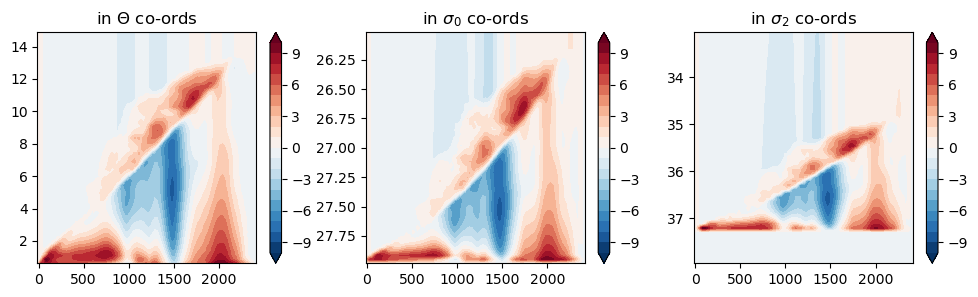

In [97]:
fig = plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 3, 1)
cs = ax.contourf(sigma_moc.gphiv, sigma_moc.sigma, sigma_moc,
                 levels=np.linspace(-10, 10, 21), cmap="RdBu_r", extend="both") 
ax.set_title(r"in $\Theta$ co-ords")
plt.colorbar(cs)

ax = plt.subplot(1, 3, 2)
cs = ax.contourf(sig0_moc.gphiv, sig0_moc.sigma, sig0_moc,
                 levels=np.linspace(-10, 10, 21), cmap="RdBu_r", extend="both") 
ax.set_title(r"in $\sigma_0$ co-ords")
ax.invert_yaxis()
plt.colorbar(cs)

ax = plt.subplot(1, 3, 3)
cs = ax.contourf(sig2_moc.gphiv, sig2_moc.sigma, sig2_moc,
                 levels=np.linspace(-10, 10, 21), cmap="RdBu_r", extend="both") 
ax.set_title(r"in $\sigma_2$ co-ords")
ax.invert_yaxis()
plt.colorbar(cs)

## cdfpsi (barotropic streamfunction)

In [ ]:
# reload(analysis)
uoce_e3u = ds_moc.uoce.mean(dim="t") * ds.e3u_0
psi_u = analysis.cdfpsi(grid, ds, uoce_e3u, **bd)

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(psi_u.glamf[:, :-1], psi_u.gphif[:, :-1], 
                 psi_u[:, :-1],
                 levels=np.linspace(-150, 150, 21), cmap="RdBu_r", extend="both")
plt.colorbar(cs)

In [ ]:
voce_e3v = ds_moc.voce.mean(dim="t") * ds.e3v_0
psi_v = analysis.cdfpsi(grid, ds, voce_e3v, **bd)

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(psi_v.glamf[:, :-1], psi_v.gphif[:, :-1], 
                 psi_v[:, :-1],
                 levels=np.linspace(-80, 80, 21), cmap="RdBu_r", extend="both")
plt.colorbar(cs)

In [ ]:
(psi_v - psi_u).values

In [ ]:
ds.gphif[:, 1].values

# Scrap code

In [ ]:
# need an "outer" axis here for z (ASSUME here for now we are not dealing with W-grid variables)
coords = {"X": {"right": "x_f", "center":"x_c"},  # xU > xT
          "Y": {"right": "y_f", "center":"y_c"},  # yV > yT
          "Z": {"center": "z_c", "outer": "z_f"},  # zW < zT !!! (?)
          "T": {"center": "t"},
          }
grid = xgcm.Grid(ds, coords=coords, metrics=metrics_dict, periodic=False)

In [ ]:
# conservative transformation (integral is preserved)
# only strictly valid for extensive quantities like transport (because the input has grid factors)

theta = grid.interp(ds.toce[0, :, :, :], ['Y'], boundary='extend')
theta_coord = np.linspace(0.1, 15, 61)

# don't select the last one since it's land, then z_f makes sense
v_trans = (ds.voce * ds.e3v_0 * ds.vmask)[0, slice(0, -1), :, :]
v_trans = v_trans.fillna(0.).rename('v_trans')

v_trans_sigma = analysis.cdfz2sig(grid, ds,                       # metrics
                                  v_trans,                        # input 
                                  theta.isel(z_c=slice(0, -1)),   # to be consistent with dims of input
                                  theta_coord,                    # new coords
                                  method="conservative", **bd)

j_ind, i_ind = 80, 40

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(v_trans[:, j_ind, i_ind], -v_trans.gdept_1d, 'C0-x')
axs[0].set_xlabel(r"$(v\Delta z)(z)$")
axs[0].set_ylabel(r"$z$")
axs[0].grid()
axs[0].set_title(r"$\int v\; {\rm d}z = \sum v \Delta z = %.8f$" 
                 % v_trans[:, j_ind, i_ind].sum("z_c").values)

axs[1].plot(v_trans_sigma[:, j_ind, i_ind], v_trans_sigma.sigma, 'C0-x')
axs[1].set_xlabel(r"$(v\Delta z)(\theta)$")
axs[1].set_ylabel(r"$\theta$")
axs[1].grid()
axs[1].set_title(r"$\int v\; {\rm d}\theta = \sum v \Delta z = %.8f$" 
                 % v_trans_sigma[:, j_ind, i_ind].sum("sigma").values)

In [ ]:
# plotting quantity on an sigma surface

sigma_ind = 11

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(v_trans_sigma.glamv[:, :-1], v_trans_sigma.gphiv[:, :-1], 
                 v_trans_sigma[sigma_ind, :, :-1],
                 levels=np.linspace(-8, 8, 21), cmap="RdBu_r", extend="both")
ax.set_title(r"$(v\Delta z)(\theta = %.2f)$" % v_trans_sigma.sigma[sigma_ind].values)
plt.colorbar(cs)


In [ ]:
# MOC in sigma-coordinates (change of coords per snapshot, then time-average)

nt = ds_moc.t.size

theta_coord = np.linspace(0.5, 15, 61)

z_sig_out = False
disp = True

for kt in range(nt):
    
    print("routine can be costly and a bit slow, have disp=True to display some progress")
    if disp:
        print(f"working at t = {kt} / {nt}...")

    theta = grid.interp(ds_moc.toce[kt, :, :, :], ['Y'], boundary='extend')

    # don't select the last one since it's land, then z_f makes sense
    v_trans = (ds_moc.voce * ds.e3v_0 * ds.vmask)[kt, slice(0, -1), :, :]
    v_trans = v_trans.fillna(0.).rename('v_trans')
    
    # create object, add to variable, then take average
    if kt == 0:
        v_trans_sigma  = analysis.cdfz2sig(ds,                             # metrics
                                           v_trans,                        # input 
                                           theta.isel(z_c=slice(0, -1)),   # to be consistent with dims of input
                                           theta_coord,                    # new coords
                                           method="conservative", **bd)
        if z_sig_out:
            dummy_coord = v_trans_sigma.sigma.values
            z_sigma    = analysis.cdfz2sig(ds, 
                                          (-ds.gdept_1d * ds.vmask)[slice(0, -1), :, :],
                                           theta.isel(z_c=slice(0, -1)),
                                           dummy_coord,
                                           **bd)
    else:
        v_trans_sigma += analysis.cdfz2sig(ds,                             # metrics
                                           v_trans,                        # input 
                                           theta.isel(z_c=slice(0, -1)),   # to be consistent with dims of input
                                           theta_coord,                    # new coords
                                           method="conservative", **bd)
        if z_sig_out:
            z_sigma   += analysis.cdfz2sig(ds, 
                                           (-ds.gdept_1d * ds.vmask)[slice(0, -1), :, :],
                                            theta.isel(z_c=slice(0, -1)),
                                            dummy_coord,
                                            **bd)
        
v_trans_sigma /= nt
z_sigma /= nt

# quick plot
sigma_ind = 6

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(v_trans_sigma.glamv[:, :-1], v_trans_sigma.gphiv[:, :-1], 
                 v_trans_sigma[sigma_ind, :, :-1],
                 levels=np.linspace(-8, 8, 21), cmap="RdBu_r", extend="both")
ax.set_title(r"$(v\Delta z)(\theta = %.2f)$" % v_trans_sigma.sigma[sigma_ind].values)
plt.colorbar(cs)

In [ ]:
# MOC in both co-ordinates for comparison

# time-averaging done in z co-ordinates
z_moc = analysis.cdfmoc(grid, ds, ds_moc.voce.mean(dim="t"), **bd)

# data time-averaged in sigma-ordinates then further manipulated
# no dsigmas here because the transformation have the e3v grid factors in
sigma_moc = (v_trans_sigma * ds.e1v).sum(dim="x_c").cumsum("sigma") / 1e6
# sigma_moc -= sigma_moc.isel({"sigma" : -1})  # already going cold -> warm (bot -> top)

sigma_moc["gphiv"] = ds.gphiv[:, 1]  # placeholder imbuement

fig = plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 3, 1)
cs = ax.contourf(z_moc.gphiv, -z_moc.gdepw_1d, z_moc,
                 levels=np.linspace(-20, 20, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

ax = plt.subplot(1, 3, 2)
cs = ax.contourf(sigma_moc.gphiv, sigma_moc.sigma, sigma_moc,
                 levels=np.linspace(-10, 10, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

# ax = plt.subplot(1, 3, 3)
# # really janky way of mean isopycnal depth averaged in density co-ordinates...
# z_avg = z_sigma.fillna(0.).mean(dim="x_c")
# gphiv_temp = np.tile(sigma_moc.gphiv.values, (sigma_moc.sizes["sigma"], 1))

# plt.contourf(gphiv_temp, z_avg, sigma_moc,
#                  levels=np.linspace(-10, 10, 21), cmap="RdBu_r", extend="both") 

In [30]:
import gsw

In [42]:
sig0 = gsw.density.sigma0(ds.soce[0, :, :, :], ds.toce[0, :, :, :]) * ds.tmask

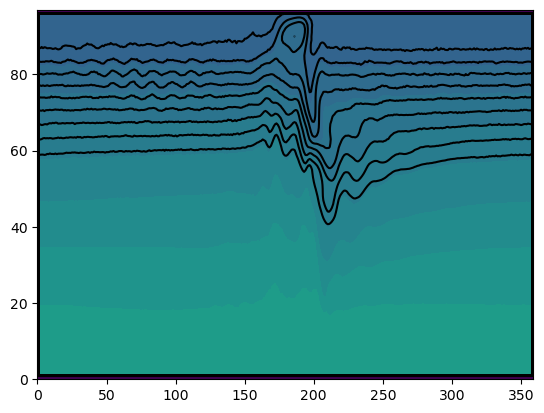

In [51]:
plt.contourf(sig0[0, :, :], np.linspace(24, 31, 31), extend="both")
plt.contour(sig0[0, :, :], np.linspace(24, 27, 31), colors="k")

In [60]:
rho = gsw.density.rho(ds.soce[0, :, :, :], ds.toce[0, :, :, :], 1000) * ds.tmask
sig1 = gsw.density.sigma1(ds.soce[0, :, :, :], ds.toce[0, :, :, :]) * ds.tmask

In [61]:
((rho[0, :, :] - 1000) - sig1[0, :, :]).values

array([[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
       [-1000.,     0.,     0., ...,     0.,     0., -1000.],
       [-1000.,     0.,     0., ...,     0.,     0., -1000.],
       ...,
       [-1000.,     0.,     0., ...,     0.,     0., -1000.],
       [-1000.,     0.,     0., ...,     0.,     0., -1000.],
       [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],
      shape=(98, 360))